<a href="https://colab.research.google.com/github/rajanm/END2_0_Session_3/blob/main/END2_Session2_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digit Recognition in PyTorch

MNIST contains around 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker. 

# Setting up the Environment

We will be using PyTorch to train a convolutional neural network to recognize MNIST's handwritten digits. A GPU runtime in Collab is being used for this notebook.

In [ ]:
import torch 
from torch import nn 
from torch.nn import functional as F
from torch import optim
import torchvision
from torch.utils.data import DataLoader
import numpy as np 

# Preparing the Dataset

With the imports in place we can go ahead and prepare the data we'll be using. But before that we'll define the hyperparameters we'll be using for the experiment. Here the number of epochs defines how many times we'll loop over the complete training dataset, while `learning_rate` is hyperparameter for the optimizer we'll be using later on.

`torch.cuda.is_available()` is used to determine the device type on which the program is running on. This is used to copy data from GPU into CPU for matplot and numpy operations as they don't work on GPU.


In [ ]:
n_epochs = 20
batch_size_train = 256
batch_size_test = 128
learning_rate = 0.01
device = None
losses = []

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print('Device (cpu/gpu aka cuda): ', device)

print('Using GPU runtime ', torch.cuda.is_available())

Device (cpu/gpu aka cuda):  cuda
Using GPU runtime  True


In [ ]:
mnist_data = torchvision.datasets.MNIST("/files/",download=True)
print(mnist_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /files/
    Split: Train


# Custom Dataset
Create a custom data set that contains the MNIST images, labels and corresponding 60,000 random numbers. In the dataset, also add the targets from MNIST and the random integers.

In [ ]:
class Dataset:

  def __init__(self,train_data):
    self.data = torch.unsqueeze((train_data.data/255.),1)
    self.integers = torch.randint(0,10,size=[60_000,])
    self.targets = mnist_data.targets
    self.int_sum = self.integers + self.targets

  def __getitem__(self,idx):

    return self.data[idx],self.integers[idx].float(),self.targets[idx],self.int_sum[idx]

  def __len__(self):

    return len(self.targets)

In [ ]:
dataset = Dataset(mnist_data)
print(dataset)

# Define the Network

Now let's go ahead and define our network. We'll use two 2-D convolutional layers followed by two fully-connected (or *linear)* layers. As activation function we'll choose [rectified linear units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (ReLUs in short) and as a means of regularization we'll use two dropout layers. 

The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better. ReLU activation functions are a very popular choice among deep learning practitioners because they are very cheap to compute. ReLU is reasonable to use for image detection because it means the neural network is almost 100% certain that the input image one of the output categories.

The model has two outputs - x1 and x2. x1 is the image recognition and x2 for the sum of the image recognition and random number.

In [ ]:
class Net(nn.Module):

  def __init__(self):

    super().__init__()
    self.conv1 = nn.Conv2d(1,10,kernel_size=5) #24
    self.pool = nn.MaxPool2d(kernel_size=2) #12
    
    self.conv2 = nn.Conv2d(10,15,kernel_size=3) #10
    self.lin1 = nn.Linear(10*10*15,50)
    self.lin2 = nn.Linear(50,10)

    self.lin3 = nn.Linear(11,20)
    self.lin4 = nn.Linear(20,19)


  def forward(self,img,num):

    x1 = F.relu(self.pool(self.conv1(img)))
    x1 = F.relu(self.conv2(x1))
    x1 = x1.view(x1.size()[0],-1)
    x1 = F.relu(self.lin1(x1))
    x1 = self.lin2(x1)

    x2 = torch.cat([x1,num[:,None]],dim=1).float()
    x2 = F.relu(self.lin3(x2))
    x2 = self.lin4(x2)

    return x1,x2

# Training Data
Load the custom dataset into a training dataset.

In [ ]:
train_loader = DataLoader(dataset,shuffle=True,batch_size=batch_size_train, 
                          num_workers=2)
img,num,target,int_sum = iter(train_loader).next()
img.shape,num.shape,target.shape,int_sum.shape

(torch.Size([256, 1, 28, 28]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256]))

# Create the Model
Create the model using the custom class defined.

In [ ]:
net = Net()
net(img,num)[0].shape,net(img,num)[1].shape

(torch.Size([256, 10]), torch.Size([256, 19]))

# Model Training
Train the model on a GPU by specifying cuda.

Adam is an algorithm for first-order gradient-based optimization. It has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. 

The cross entropy loss criterion combines LogSoftmax and NLLLoss in one single class. This loss criterion is the default loss function to use for binary or multi-class classification problems. Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem.

As a best practice, explicitly set the intent to train the model.

The state of the model and the optimizer are also saved for using them in future for further training.

In [ ]:
def train(epochs,lr,losses):
  optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  
  net.train()
  for epoch in range(epochs):
    
    if torch.cuda.is_available() == True:   
      net.cuda()
        
    for batch in train_loader:
      
      img,num,target,int_sum = batch 
      if torch.cuda.is_available() == True:   
        out1,out2 = net(img.cuda(),num.cuda())
        loss1 = criterion(out1,target.cuda())
        loss2 = criterion(out2,int_sum.cuda())
        loss = loss1 + loss2
      else:
        out1,out2 = net(img,num)
        loss1 = criterion(out1,target)
        loss2 = criterion(out2,int_sum)
        loss = loss1 + loss2

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      torch.save(net.state_dict(), '/files/model.pth')
      torch.save(optimizer.state_dict(), '/files/optimizer.pth')

    losses.append(loss.item())
    print(f"epoch:{epoch+1} loss : {losses[epoch]}")

In [ ]:
train(n_epochs,learning_rate,losses)

epoch:1 loss : 0.10954839736223221
epoch:2 loss : 0.15206612646579742
epoch:3 loss : 0.12322311848402023
epoch:4 loss : 0.30127111077308655
epoch:5 loss : 0.28681278228759766
epoch:6 loss : 0.16947250068187714
epoch:7 loss : 0.150152325630188
epoch:8 loss : 0.08702650666236877
epoch:9 loss : 0.24924281239509583
epoch:10 loss : 0.3336752951145172
epoch:11 loss : 0.16317225992679596
epoch:12 loss : 0.06888280808925629
epoch:13 loss : 0.14698024094104767
epoch:14 loss : 0.08581708371639252
epoch:15 loss : 0.09252146631479263
epoch:16 loss : 0.17057819664478302
epoch:17 loss : 0.20203369855880737
epoch:18 loss : 0.06819264590740204
epoch:19 loss : 0.09341076016426086
epoch:20 loss : 0.17318454384803772


In [ ]:
!ls /files/ -alh
!ls /files/MNIST/ -alh

total 936K
drwxr-xr-x 3 root root 4.0K May 21 17:17 .
drwxr-xr-x 1 root root 4.0K May 21 16:46 ..
drwxr-xr-x 4 root root 4.0K May 21 16:46 MNIST
-rw-r--r-- 1 root root 308K May 21 17:53 model.pth
-rw-r--r-- 1 root root 615K May 21 17:53 optimizer.pth
total 16K
drwxr-xr-x 4 root root 4.0K May 21 16:46 .
drwxr-xr-x 3 root root 4.0K May 21 17:17 ..
drwxr-xr-x 2 root root 4.0K May 21 16:46 processed
drwxr-xr-x 2 root root 4.0K May 21 16:46 raw


# Evaluating the Model's Performance

With just 20 epochs of training we managed to reduce the loss. Let's plot our training loss curve.

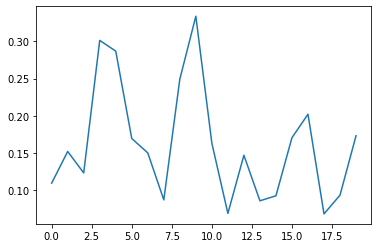

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)